prompt:  load the parquet fies we created in the other two notebooks and perform
a regression to analyze the relationship between median income of a tract
(independent variable ) and the average download speeds (dependent variable ) in
that tract. You will need to do a spatial join on the two dataset, to locate
each point from the uss_mobile_2022q1 dataset to a census tract, then aggregate
by tract, computing the average or median download speed or upload speed. You
should create an analysis function to parameterize which statistic of central
tendencay we use, and which dependent variable we use. Use statsmodel for the OLS. 

## Updates

[ When you have completed an update, put `[DONE]` in front of it, after the bullet. ]

* [DONE] You do not need to create Points from tile_x and til_y in the uss_mobile dataset, there is already a geometry field. You might have to use shapely.loads to convert that from a string to a geometry, but check first.

* [DONE] Aggregating the joined dataset:  average these fields: ['avg_d_kbps',
  'avg_u_kbps', 'avg_lat_ms', 'avg_lat_down_ms', 'avg_lat_up_ms']. sum these
  fields: ['tests', 'devices']. group by: 'GEOID'. There should be only one
  'median_income', and it should be passed through. 



In [1]:
 # Enable autoreload and import libraries
%load_ext autoreload
%autoreload 2

import pandas as pd
import geopandas as gpd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Load configuration
data_dir = None
%run ../../config.py


Project root: /Users/eric/proj/scratch/WirelessIncome
Data directory: /Users/eric/proj/scratch/WirelessIncome/data


In [2]:

# Paths to parquet files produced by other notebooks
mobile_path = data_dir/"uss_mobile_2022.parquet"
tracts_path = data_dir/"tracts_with_income_2022.parquet"

# Load datasets
mobile_gdf = gpd.read_parquet(mobile_path)
tracts_gdf = gpd.read_parquet(tracts_path)


type(mobile_gdf), type(tracts_gdf)

(geopandas.geodataframe.GeoDataFrame, geopandas.geodataframe.GeoDataFrame)

In [3]:
print(f"Mobile data rows: {len(mobile_gdf)}")
print(f"Tracts: {len(tracts_gdf)}")

# Reproject to a common CRS for spatial operations
mobile_gdf = mobile_gdf.to_crs(epsg=3857)
tracts_gdf = tracts_gdf.to_crs(epsg=3857)

# Spatial join: assign each speed point to a tract
joined = gpd.sjoin(
    mobile_gdf,
    tracts_gdf[["GEOID", "median_income", "geometry"]],
    how="inner",
    predicate="within",
)

print(f"Joined rows: {len(joined)}")
joined.head()

Mobile data rows: 4066168
Tracts: 83225
Joined rows: 2473948


,avg_d_kbps,avg_u_kbps,avg_lat_ms,avg_lat_down_ms,avg_lat_up_ms,tests,devices,ookla_year,ookla_quarter,ookla_service_type,geometry,index_right,GEOID,median_income
6301,1174,391,21,NaN,NaN,1,1,2022,1,mobile,POINT (-13700267.843 6272418.368),81316,53073011000,74400.0
7613,79001,10337,58,NaN,NaN,9,1,2022,1,mobile,POINT (-13697206.557 6273029.059),81316,53073011000,74400.0
7655,82789,9935,41,NaN,NaN,2,1,2022,1,mobile,POINT (-13664801.453 6274250.571),5161,53073010409,75239.0
7656,267211,50343,28,NaN,NaN,2,2,2022,1,mobile,POINT (-13664189.196 6274861.394),5161,53073010409,75239.0
7657,144491,16647,26,NaN,NaN,1,1,2022,1,mobile,POINT (-13667250.482 6273029.059),14650,53073010405,95288.0


In [4]:
# Aggregation function and OLS helper
import numpy as np

def aggregate_speeds(joined_gdf, by="GEOID", var="avg_d_kbps", stat="mean"):
    """
    Aggregate speeds by tract with chosen statistic.
    stat: 'mean' | 'median'
    var: column in joined_gdf for dependent variable (e.g., 'avg_d_kbps', 'avg_u_kbps')
    
    Aggregates:
    - Average: avg_d_kbps, avg_u_kbps, avg_lat_ms, avg_lat_down_ms, avg_lat_up_ms
    - Sum: tests, devices
    - Pass through: median_income
    """
    agg_dict = {
        'avg_d_kbps': stat,
        'avg_u_kbps': stat,
        'avg_lat_ms': stat,
        'avg_lat_down_ms': stat,
        'avg_lat_up_ms': stat,
        'tests': 'sum',
        'devices': 'sum',
        'median_income': 'first'
    }
    
    return joined_gdf.groupby(by).agg(agg_dict).reset_index()
    
# Example: aggregate using mean download speed and run OLS
agg_df = aggregate_speeds(joined, var="avg_d_kbps", stat="mean")


In [5]:
# Load total population and merge with the aggregated speeds dataframe
pop_path = data_dir/"totalpop_acs5_2022.parquet"
pop_df = pd.read_parquet(pop_path)
print('Population rows:', len(pop_df))
print('Population columns:', list(pop_df.columns))

# Merge on GEOID; keep all aggregated tracts and bring population in where available
merged = agg_df.merge(pop_df, on='GEOID', how='left')

# Quick checks
print('Merged rows:', len(merged))
merged.columns
merged.head()

Population rows: 85396
Population columns: ['GEOID', 'NAME', 'population', 'acs_year', 'state', 'county', 'tract']
Merged rows: 82193


,GEOID,avg_d_kbps,avg_u_kbps,avg_lat_ms,avg_lat_down_ms,avg_lat_up_ms,tests,devices,median_income,NAME,population,acs_year,state,county,tract
0,01001020100,76925.869565,6738.391304,44.565217,976.900000,1227.500000,35,29,60563.0,Census Tract 201; Autauga County; Alabama,1865,2022,01,001,020100
1,01001020200,42598.933333,11000.466667,69.200000,776.142857,1896.285714,25,17,57460.0,Census Tract 202; Autauga County; Alabama,1861,2022,01,001,020200
2,01001020300,122265.500000,19900.909091,34.545455,774.875000,678.500000,67,31,77371.0,Census Tract 203; Autauga County; Alabama,3492,2022,01,001,020300
3,01001020400,102976.833333,12908.055556,34.111111,934.200000,891.800000,40,26,73191.0,Census Tract 204; Autauga County; Alabama,3987,2022,01,001,020400
4,01001020501,96890.684211,15907.368421,28.105263,572.700000,717.600000,60,29,79953.0,Census Tract 205.01; Autauga County; Alabama,4121,2022,01,001,020501


In [6]:
merged.head()

,GEOID,avg_d_kbps,avg_u_kbps,avg_lat_ms,avg_lat_down_ms,avg_lat_up_ms,tests,devices,median_income,NAME,population,acs_year,state,county,tract
0,01001020100,76925.869565,6738.391304,44.565217,976.900000,1227.500000,35,29,60563.0,Census Tract 201; Autauga County; Alabama,1865,2022,01,001,020100
1,01001020200,42598.933333,11000.466667,69.200000,776.142857,1896.285714,25,17,57460.0,Census Tract 202; Autauga County; Alabama,1861,2022,01,001,020200
2,01001020300,122265.500000,19900.909091,34.545455,774.875000,678.500000,67,31,77371.0,Census Tract 203; Autauga County; Alabama,3492,2022,01,001,020300
3,01001020400,102976.833333,12908.055556,34.111111,934.200000,891.800000,40,26,73191.0,Census Tract 204; Autauga County; Alabama,3987,2022,01,001,020400
4,01001020501,96890.684211,15907.368421,28.105263,572.700000,717.600000,60,29,79953.0,Census Tract 205.01; Autauga County; Alabama,4121,2022,01,001,020501


<Axes: >

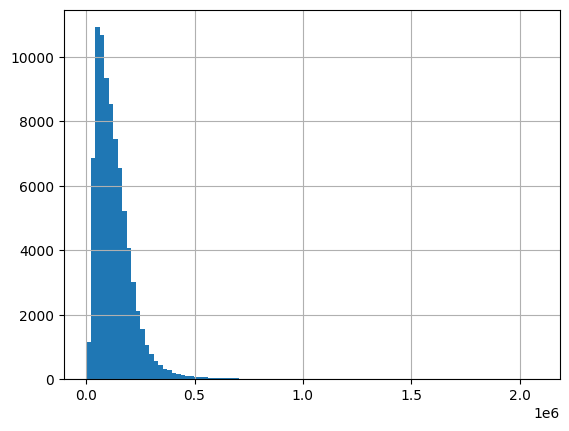

In [9]:
agg_df.avg_d_kbps.hist(bins=100)

<Axes: >

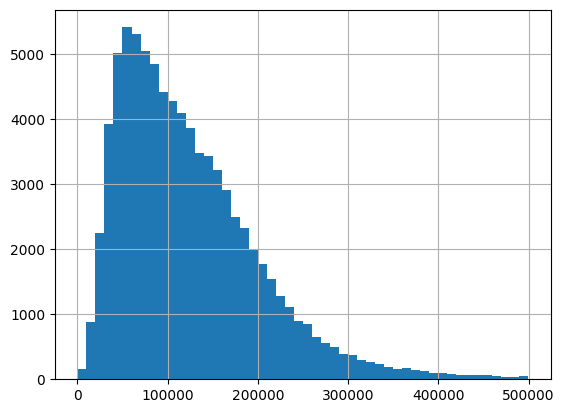

In [10]:
agg_df[agg_df.avg_d_kbps < 500_000].avg_d_kbps.hist(bins=50)

<Axes: >

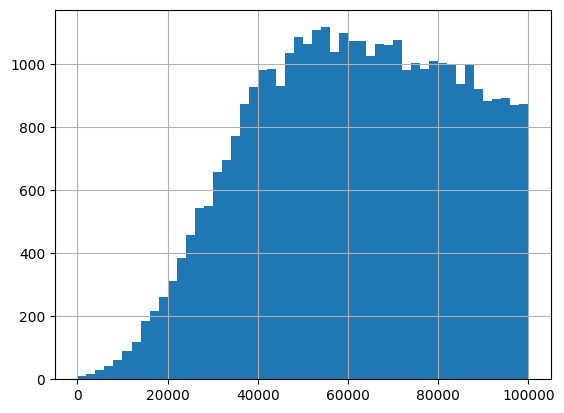

In [11]:


agg_df[agg_df.avg_d_kbps < 100_000].avg_d_kbps.hist(bins=50)

In [12]:
x = (agg_df.avg_d_kbps < 60_000).value_counts()
x[True]/len(agg_df)

np.float64(0.2145924835448274)

Looks like there is a a linear part below 40,000, so maybe just analyze that. 

<Axes: >

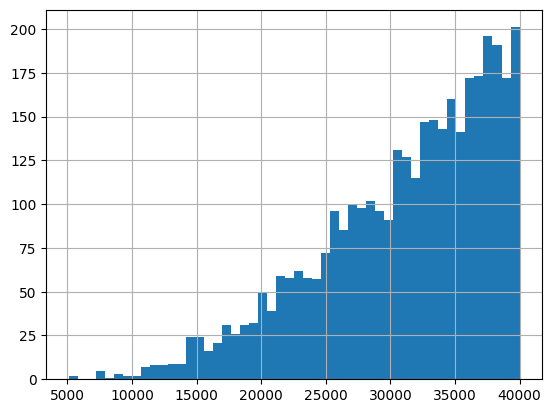

In [13]:
t = agg_df.copy()
t = t[t.tests > 50]

t = t[t.avg_d_kbps < 40000]

t.avg_d_kbps.hist(bins=50)

                            OLS Regression Results                            
Dep. Variable:             avg_d_kbps   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     26.71
Date:                Sun, 07 Dec 2025   Prob (F-statistic):           2.49e-07
Time:                        16:57:40   Log-Likelihood:                -36851.
No. Observations:                3601   AIC:                         7.371e+04
Df Residuals:                    3599   BIC:                         7.372e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2.957e+04    309.579     95.509

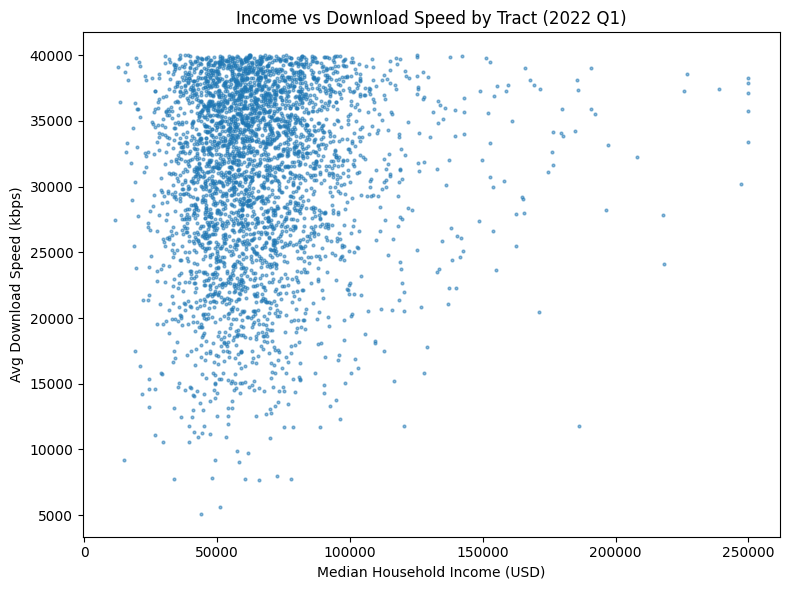

In [14]:
x_var = "median_income"
y_var = "avg_d_kbps"

t = agg_df.copy()
t = t[t.tests > 50]

t = t[t.avg_d_kbps < 40000]


X = sm.add_constant(t[x_var])  # add intercept

y = t[y_var]

model = sm.OLS(y, X, missing="drop").fit()

print(model.summary())

# Quick scatter plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(t[x_var], t[y_var], s=4, alpha=0.5)
ax.set_xlabel("Median Household Income (USD)")
ax.set_ylabel("Avg Download Speed (kbps)")
ax.set_title("Income vs Download Speed by Tract (2022 Q1)")
plt.tight_layout()
plt.show()

                            OLS Regression Results                            
Dep. Variable:             avg_d_kbps   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     277.8
Date:                Sun, 07 Dec 2025   Prob (F-statistic):           2.86e-62
Time:                        17:04:38   Log-Likelihood:            -1.0589e+06
No. Observations:               82193   AIC:                         2.118e+06
Df Residuals:                   82191   BIC:                         2.118e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1139.9101   7663.47

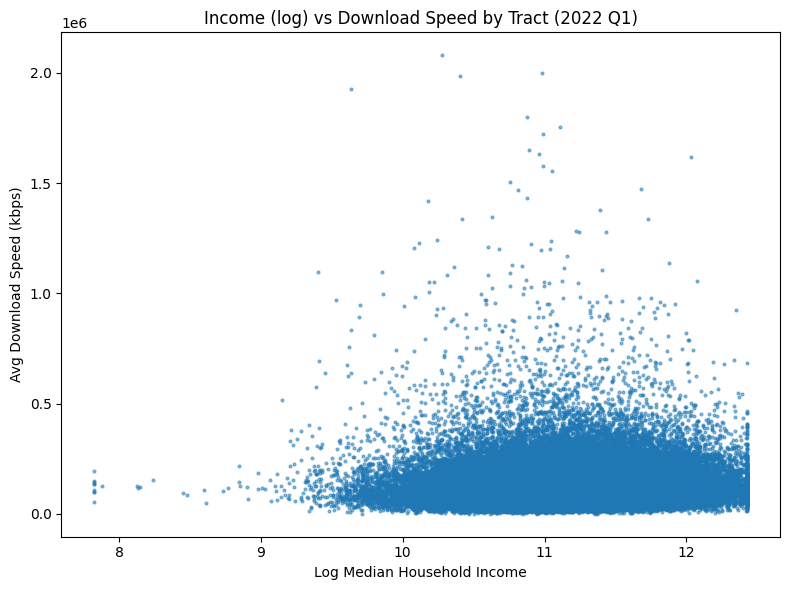

In [18]:
# Repeat the model with log-transformed median income
t_log = agg_df.copy()

t_log = t_log.assign(log_median_income=np.log(t_log.median_income))

X_log = sm.add_constant(t_log["log_median_income"])
y_log = t_log["avg_d_kbps"]

model_log = sm.OLS(y_log, X_log, missing="drop").fit()
print(model_log.summary())

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(t_log["log_median_income"], t_log["avg_d_kbps"], s=4, alpha=0.5)
ax.set_xlabel("Log Median Household Income")
ax.set_ylabel("Avg Download Speed (kbps)")
ax.set_title("Income (log) vs Download Speed by Tract (2022 Q1)")
plt.tight_layout()
plt.show()

<Axes: >

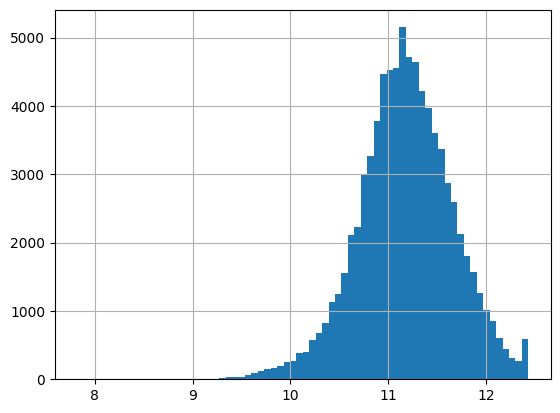

In [17]:
import numpy as np

np.log(agg_df.median_income).hist(bins=70)